In [1]:
import datetime

%matplotlib inline
import matplotlib.pyplot as pd
from IPython.display import display, YouTubeVideo

import arcgis
from arcgis.gis import GIS
from arcgis.features.analyze_patterns import interpolate_points
from arcgis.geocoding import geocode
from arcgis.features.find_locations import trace_downstream
from arcgis.features.use_proximity import create_buffers

gis = GIS(profile = "your_online_profile")

Profile your_online_profile does not have a password on file through keyring. If you are expecting this behavior (PKI or IWA authentication, entering password through run-time prompt, etc.), please ignore this message. If you would like to store your password in the your_online_profile profile, run GIS(profile = 'your_online_profile', password = ...). See the API doc for more details. (http://bit.ly/2CK2wG8)


In [2]:
import datetime

%matplotlib inline
import matplotlib.pyplot as pd
from IPython.display import display, YouTubeVideo

import arcgis
from arcgis.gis import GIS
from arcgis.features.analyze_patterns import interpolate_points
from arcgis.geocoding import geocode
from arcgis.features.find_locations import trace_downstream
from arcgis.features.use_proximity import create_buffers

gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")

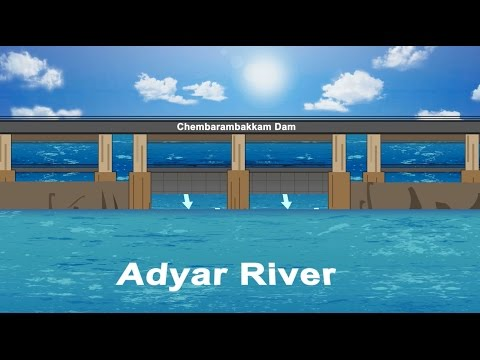

In [3]:
YouTubeVideo('x4dNIfx6HVs')

In [4]:
map = gis.map("Chennai")
map

MapView(layout=Layout(height='400px', width='100%'))

In [5]:
chennaipop = gis.content.search("Chennai_Population", 
                                item_type="Feature Layer", 
                                outside_org=True)[0]
chennaipop

IndexError: list index out of range

In [6]:
map.add_layer(chennaipop, {"renderer":"ClassedColorRenderer", 
                           "field_name": "TOTPOP_CY", 
                           "opacity":0.7})

NameError: name 'chennaipop' is not defined

In [7]:
search_rainfall = gis.content.search("Chennai_precipitation", 
                              item_type="Feature Layer", 
                              outside_org=True)
if len(search_rainfall) >= 1:
    rainfall = search_rainfall[0]
else:
    # if the "Chennai_precipitation" web layer does not exist
    print("Web Layer does not exist. Re-publishing...")
    # import any pandas data frame, with an address field, as a layer in our GIS
    import pandas as pds
    df = pds.read_csv('data/Chennai_precipitation.csv')
    # Create an arcgis.features.FeatureCollection object by importing the pandas dataframe with an address field
    rainfall = gis.content.import_data(df, {"Address" : "LOCATION"})

In [8]:
map2 = gis.map("Tamil Nadu, India")
map2

MapView(layout=Layout(height='400px', width='100%'))

In [9]:
interpolated_rf = interpolate_points(rainfall, field='RAINFALL')

In [10]:
intmap = gis.map("Tamil Nadu")
intmap

MapView(layout=Layout(height='400px', width='100%'))

In [11]:
intmap.add_layer(interpolated_rf['result_layer'])

In [12]:
lakemap = gis.map("Chennai")
lakemap.height='450px'
lakemap

MapView(layout=Layout(height='400px', width='100%'))

In [13]:
lakemap.draw(geocode("Chembarambakkam, Tamil Nadu")[0], 
             {"title": "Chembarambakkam", "content": "Water reservoir"})
lakemap.draw(geocode("Puzhal Lake, Tamil Nadu")[0], 
             {"title": "Puzhal", "content": "Water reservoir"})
lakemap.draw(geocode("Kannampettai, Tamil Nadu")[0], 
             {"title": "Poondi Lake ", "content": "Water reservoir"})

In [14]:
search_results = gis.content.search("Chennai_lakes", 
                                   item_type="Feature Layer",
                                   outside_org=True)
search_results

[<Item title:"chennai_lakes" type:Feature Layer Collection owner:lizgraham_gp2>,
 <Item title:"Chennai Lakes OverFlow Path" type:Feature Layer Collection owner:Balaganesh99>,
 <Item title:"Possible Flood Zones" type:Feature Layer Collection owner:Balaganesh99>,
 <Item title:"Chennai_lakes" type:Feature Layer Collection owner:esri_notebook>]

<Item title:"Possible Flood Zones" type:Feature Layer Collection owner:Balaganesh99>
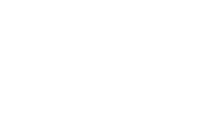

In [15]:
chennai_lakes = search_results[2]
chennai_lakes

In [16]:
downstream = trace_downstream(chennai_lakes)
downstream.query()

{"messageCode": "AO_100091", "message": "The input layer must be point geometry.", "params": {"paramName": "input layer"}}
{"messageCode": "AO_100122", "message": "TraceDownstream failed."}
Failed to execute (TraceDownstream).
Failed.


Exception: Job failed.

In [ ]:
floodprone_buffer = create_buffers(downstream, [ 1 ], units='Miles')

In [ ]:
lakemap.add_layer(floodprone_buffer)

<Item title:"Landsat GLS Multispectral" type:Imagery Layer owner:esri>
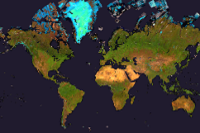

In [17]:
def exact_search(my_gis, title, owner_value, item_type_value, max_items_value=20):
    final_match = None
    search_result = my_gis.content.search(query= title + ' AND owner:' + owner_value, 
                                          item_type=item_type_value, max_items=max_items_value, outside_org=True)
    
    if "Imagery Layer" in item_type_value:
        item_type_value = item_type_value.replace("Imagery Layer", "Image Service")
    elif "Layer" in item_type_value:
        item_type_value = item_type_value.replace("Layer", "Service")
    
    for result in search_result:
        if result.title == title:
            final_match = result
            break
    return final_match

ls_water = exact_search(gis, 'Landsat GLS Multispectral', 'esri', 'Imagery Layer')
ls_water

In [18]:
ls_water_lyr = ls_water.layers[0]

In [19]:
from arcgis.geocoding import geocode
area = geocode("Tamil Nadu, India", out_sr=ls_water_lyr.properties.extent.spatialReference)[0]
ls_water_lyr.extent = area['extent']

In [20]:
# data source option 
from arcgis.raster.functions import stretch, extract_band
target_img_layer = stretch(extract_band(ls_water_lyr, [5,4,3]),
                           stretch_type="percentclip", gamma=[1,1,1], dra=True)

In [21]:
import pandas as pd
from arcgis import geometry
import datetime as dt

def filter_images(my_map, start_year, end_year):
    selected = target_img_layer.filter_by(where="(Category = 1) AND (CloudCover <=0.2)",
                                          time=[dt.datetime(start_year, 1, 1), dt.datetime(end_year, 1, 1)],
                                          geometry=arcgis.geometry.filters.intersects(ls_water_lyr.extent))
    my_map.add_layer(selected)
    
    fs = selected.query(out_fields="AcquisitionDate, GroupName, Month, DayOfYear, WRS_Row, WRS_Path")
    tdf = fs.sdf  
    return tdf

In [22]:
satmap1 = gis.map("Pallikaranai, Tamil Nadu, India", 13)
df = filter_images(satmap1, 1991, 1992) 
df.head()

C:\Users\kylie\Anaconda3\envs\arcgispythonapi_real\lib\site-packages\IPython\lib\pretty.py:402: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  return _repr_pprint(obj, self, cycle)
C:\Users\kylie\Anaconda3\envs\arcgispythonapi_real\lib\site-packages\pandas\io\formats\html.py:606: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  super().render()


,OBJECTID,AcquisitionDate,GroupName,Month,DayOfYear,WRS_Row,WRS_Path,Shape_Length,Shape_Area,SHAPE
0,34297,1991-08-25,p142r051_5x19910825,8,237,51,142,711646.676375,3.157366e+10,"{""rings"": [[[9024389.361699998, 1418416.124200..."
1,34300,1991-08-25,p142r052_5x19910825,8,237,52,142,707233.012677,3.118276e+10,"{""rings"": [[[8988407.6618, 1253748.178100001],..."
2,34341,1991-04-10,p143r051_5x19910410,4,100,51,143,719956.694300,3.231922e+10,"{""rings"": [[[8854469.6882, 1418030.1556000002]..."
3,34298,1991-01-29,p142r052_5x19910129,1,29,52,142,716418.700482,3.199999e+10,"{""rings"": [[[8988705.9855, 1253944.3066000007]..."
4,34301,1991-01-29,p142r053_5x19910129,1,29,53,142,713084.857110,3.170226e+10,"{""rings"": [[[8953190.746100001, 1089696.012499..."


In [23]:
satmap2 = gis.map("Pallikaranai, Tamil Nadu, India", 13)
df = filter_images(satmap2, 2009, 2010)
df.head()

,OBJECTID,AcquisitionDate,GroupName,Month,DayOfYear,WRS_Row,WRS_Path,Shape_Length,Shape_Area,SHAPE
0,7062,2009-03-04,L7141053_05320090304,3,63,53,141,739524.845354,3.403963e+10,"{""rings"": [[[9157743.0141, 1206720.0223000012]..."
1,7085,2009-02-14,L7143054_05420090214,2,45,54,143,735881.614907,3.374058e+10,"{""rings"": [[[8780336.5403, 1043432.0866999999]..."
2,3112,2009-03-03,L5142053_05320090303,3,62,53,142,733068.511329,3.349556e+10,"{""rings"": [[[8988128.4335, 1202891.985199999],..."
3,3146,2009-01-21,L5143051_05120090121,1,21,51,143,739594.538531,3.409762e+10,"{""rings"": [[[8889603.408100002, 1533573.856199..."
4,7094,2009-01-20,L7144052_05220090120,1,20,52,144,738881.696015,3.403042e+10,"{""rings"": [[[8680469.743299998, 1371205.350800..."


In [24]:
from ipywidgets import *

satmap1.layout=Layout(flex='1 1', padding='10px', height='300px')
satmap2.layout=Layout(flex='1 1', padding='10px', height='300px')

box = HBox([satmap1, satmap2])
box

In [25]:
relief_centers = gis.content.search("Chennai Relief Centers")[0]

IndexError: list index out of range

In [26]:
reliefmap = gis.map("Chennai")
reliefmap

MapView(layout=Layout(height='400px', width='100%'))

In [27]:
reliefmap.add_layer(chennaipop, {"opacity":0.5})

NameError: name 'chennaipop' is not defined

In [28]:
reliefmap.add_layer(relief_centers)

NameError: name 'relief_centers' is not defined

In [29]:
relief_data = relief_centers.layers[0].query().sdf
relief_data.head()

NameError: name 'relief_centers' is not defined

In [30]:
relief_data['No_of_pers'].sum()

NameError: name 'relief_data' is not defined

In [31]:
relief_data['No_of_pers'].describe()

NameError: name 'relief_data' is not defined

In [32]:
relief_data['No_of_pers'].hist()

NameError: name 'relief_data' is not defined

In [33]:
relief_data.shape

NameError: name 'relief_data' is not defined

In [34]:
chennai_pop_featurelayer = chennaipop.layers[0]

NameError: name 'chennaipop' is not defined

In [35]:
res = arcgis.features.summarize_data.aggregate_points(  relief_centers, 
                                                        chennai_pop_featurelayer, 
                                                        False, 
                                                        ["No_of_pers Sum"])

NameError: name 'relief_centers' is not defined

In [36]:
aggr_lyr = res['aggregated_layer']

NameError: name 'res' is not defined

In [37]:
reliefmap.add_layer(aggr_lyr, { "renderer": "ClassedSizeRenderer", 
                               "field_name":"SUM_No_of_pers"})

NameError: name 'aggr_lyr' is not defined

In [38]:
df = aggr_lyr.query().sdf
df.head()

NameError: name 'aggr_lyr' is not defined

In [39]:
df = aggr_lyr.query().sdf

df2 = df[['NAME', 'SUM_No_of_pers']]
df2.set_index('NAME', inplace=True)
df2

NameError: name 'aggr_lyr' is not defined

In [40]:
df2.plot(kind='bar')

NameError: name 'df2' is not defined

In [41]:
routemap = gis.map("Chennai")
routemap

MapView(layout=Layout(height='400px', width='100%'))

In [42]:
nehru_stadium = geocode('Jawaharlal Nehru Stadium, Chennai')[0]
routemap.draw(nehru_stadium, {"title": "Nehru Stadium", 
                              "content": "Chennai Flood Relief Center"})

In [43]:
start_time = datetime.datetime(2015, 12, 13, 9, 0)

In [44]:
routes = arcgis.features.use_proximity.plan_routes(
    relief_centers, 
    15, 
    15, 
    start_time, 
    nehru_stadium, 
    stop_service_time=30)
routemap.add_layer(routes['routes_layer'])

NameError: name 'relief_centers' is not defined

In [45]:
routemap.add_layer(routes['assigned_stops_layer'])

NameError: name 'routes' is not defined